# Credit Card Fraud Study

Developped by Alexandre Le Mercier. *This code is under the MIT license as the rest of this package content (cf. the README.md file).*

In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import os
import sys
import tqdm as tq
from tqdm.notebook import tqdm
import warnings
import gc
import xgboost as xg
import lightgbm as lgb
import sklearn as sk
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
import optuna

libraries = [pd, np, sns, tq, xg, lgb, sk, optuna]

warnings.filterwarnings("ignore")

# Print Python's version
print(f'Python version: {sys.version}\n')

# Print libraries versions
for lib in libraries:
    print(f'{lib.__name__}: {lib.__version__}')

# Set pandas options
pd.set_option('display.max_columns', 500)

# Print today's date
print("\nLast run: ", date.today())

Python version: 3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]

pandas: 2.2.3
numpy: 2.1.3
seaborn: 0.13.2
tqdm: 4.67.0
xgboost: 2.1.2
lightgbm: 4.5.0
sklearn: 1.5.2
optuna: 4.0.0

Last run:  2024-12-15


In [3]:
df = pd.read_csv("../data/card_transdata.csv/card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
xgb = XGBClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42,verbose=-1)
etc = ExtraTreesClassifier(random_state=42)
hgbc = HistGradientBoostingClassifier(random_state=42)

TARGET = 'fraud'

models = [xgb, lgb, etc, hgbc]
X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, axis=1), df[TARGET], test_size=0.2, random_state=42)

In [ ]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model.__class__.__name__} accuracy: {accuracy_score(y_test, y_pred)} f1: {f1_score(y_test, y_pred)}")

XGBClassifier accuracy: 0.998155 f1: 0.9894260251597559
LGBMClassifier accuracy: 0.998855 f1: 0.993453589091221
ExtraTreesClassifier accuracy: 0.999595 f1: 0.9976752862841891
HistGradientBoostingClassifier accuracy: 0.998485 f1: 0.9913103329605093


In [6]:
# Match feature importance of each model with feature names (except for HistGradientBoostingClassifier)
for model in models:
    if model.__class__.__name__ != 'HistGradientBoostingClassifier':
        feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
        print(f"{model.__class__.__name__} feature importances:")
        print(feature_importances)

XGBClassifier feature importances:
                                importance
online_order                      0.405270
ratio_to_median_purchase_price    0.185790
used_pin_number                   0.122453
used_chip                         0.120168
repeat_retailer                   0.108906
distance_from_home                0.041703
distance_from_last_transaction    0.015710
LGBMClassifier feature importances:
                                importance
distance_from_home                     723
distance_from_last_transaction         720
ratio_to_median_purchase_price         501
used_pin_number                        398
used_chip                              276
online_order                           271
repeat_retailer                        111
ExtraTreesClassifier feature importances:
                                importance
ratio_to_median_purchase_price    0.644492
distance_from_home                0.199417
distance_from_last_transaction    0.072443
online_order               

In [ ]:
# Optuna grid for XGBoost
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state': 42
    }
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-20 15:25:29,903] A new study created in memory with name: no-name-3c30c558-74f2-4abb-9092-67ecc97af728
[I 2024-11-20 15:25:59,720] Trial 0 finished with value: 0.9740478402229448 and parameters: {'learning_rate': 0.055717032118690585, 'max_depth': 10, 'subsample': 0.8134649456247576, 'colsample_bytree': 0.2683275254990483, 'gamma': 5.602211702046802e-05, 'min_child_weight': 172, 'reg_alpha': 0.00017401629300847253, 'reg_lambda': 0.0001362977678427805}. Best is trial 0 with value: 0.9740478402229448.
[I 2024-11-20 15:26:21,766] Trial 1 finished with value: 0.9826813889126651 and parameters: {'learning_rate': 0.296555315705235, 'max_depth': 4, 'subsample': 0.26247216462650635, 'colsample_bytree': 0.19433544074142106, 'gamma': 6.412137293652065e-06, 'min_child_weight': 239, 'reg_alpha': 4.735124375509738e-05, 'reg_lambda': 0.00026315907114732214}. Best is trial 1 with value: 0.9826813889126651.
[I 2024-11-20 15:26:45,661] Trial 2 finished with value: 0.9743306812242291 and para

In [9]:
# Optimization grid for LightGBM
def objective(trial):
    param = {
        'objective': 'binary',
        'verbose': -1,
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state': 42
    }
    model = LGBMClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-20 15:42:05,605] A new study created in memory with name: no-name-39ff7281-8bdc-434f-96f0-35de80cfc3a7
[I 2024-11-20 15:42:15,597] Trial 0 finished with value: 0.9918880319908597 and parameters: {'learning_rate': 0.11673779699139929, 'max_depth': 5, 'subsample': 0.2831640754241587, 'colsample_bytree': 0.1857098630499125, 'reg_alpha': 1.0162630861916187e-07, 'reg_lambda': 0.0010797901567333188}. Best is trial 0 with value: 0.9918880319908597.
[I 2024-11-20 15:42:26,721] Trial 1 finished with value: 0.9921792190678087 and parameters: {'learning_rate': 0.07120863083756623, 'max_depth': 7, 'subsample': 0.7947713341854947, 'colsample_bytree': 0.9384747396600377, 'reg_alpha': 0.001782851226902325, 'reg_lambda': 0.00319467491219979}. Best is trial 1 with value: 0.9921792190678087.
[I 2024-11-20 15:42:34,734] Trial 2 finished with value: 0.9923039510199411 and parameters: {'learning_rate': 0.0582971336861329, 'max_depth': 2, 'subsample': 0.8119436759464816, 'colsample_bytree': 0.701

In [12]:
# Same for HistGradientBoostingClassifier
def objective(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-8, 1.0),
        'max_bins': trial.suggest_int('max_bins', 2, 255),
        'random_state': 42
    }
    model = HistGradientBoostingClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-20 15:53:00,910] A new study created in memory with name: no-name-a792f056-ccca-4940-a978-0197c77ffe9c
[I 2024-11-20 15:53:03,943] Trial 0 finished with value: 0.9903307014532555 and parameters: {'learning_rate': 0.02091708046035103, 'max_depth': 28, 'l2_regularization': 0.00013756153842214212, 'max_bins': 250}. Best is trial 0 with value: 0.9903307014532555.
[I 2024-11-20 15:53:07,197] Trial 1 finished with value: 0.9876772304212937 and parameters: {'learning_rate': 0.07392940927373393, 'max_depth': 99, 'l2_regularization': 0.001646899415416527, 'max_bins': 208}. Best is trial 0 with value: 0.9903307014532555.
[I 2024-11-20 15:53:08,987] Trial 2 finished with value: 0.9873497968475348 and parameters: {'learning_rate': 0.22804325687809165, 'max_depth': 56, 'l2_regularization': 0.0034310305837649594, 'max_bins': 187}. Best is trial 0 with value: 0.9903307014532555.
[I 2024-11-20 15:53:12,068] Trial 3 finished with value: 0.9218909966877447 and parameters: {'learning_rate': 0.

In [14]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, min(min_samples_split - 1, 20))
    max_features = trial.suggest_uniform('max_features', 0.1, 1.0)

    param = {
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'random_state': 42
    }

    model = ExtraTreesClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-11-20 16:03:06,728] A new study created in memory with name: no-name-6782156d-d5e2-4859-bbaa-3d95a777fb87
[I 2024-11-20 16:03:46,283] Trial 0 finished with value: 0.9537234202081396 and parameters: {'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 0.9372793018130161}. Best is trial 0 with value: 0.9537234202081396.
[I 2024-11-20 16:04:02,665] Trial 1 finished with value: 0.0053744997141223555 and parameters: {'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 0.664417124233858}. Best is trial 0 with value: 0.9537234202081396.
[I 2024-11-20 16:04:25,431] Trial 2 finished with value: 0.7317871164752072 and parameters: {'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.13333039095473362}. Best is trial 0 with value: 0.9537234202081396.
[I 2024-11-20 16:05:06,170] Trial 3 finished with value: 0.9950747429361445 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 

In [12]:
extra_trees_best_params = {'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.907244139860713}
model = ExtraTreesClassifier(**extra_trees_best_params, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"ExtraTreesClassifier accuracy: {accuracy_score(y_test, y_pred)} f1: {f1_score(y_test, y_pred)}")
# feature importances
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("ExtraTreesClassifier feature importances:")
print(feature_importances)

ExtraTreesClassifier accuracy: 0.987065 f1: 0.9199046410105576
ExtraTreesClassifier feature importances:
                                importance
ratio_to_median_purchase_price    0.657694
distance_from_home                0.159689
online_order                      0.074261
distance_from_last_transaction    0.043188
used_pin_number                   0.032980
used_chip                         0.026230
repeat_retailer                   0.005959


In [10]:
def absolute_custom_cost(x, xi, alpha=1):
    return np.sqrt((x[0]-xi[0])**2+(x[1]-xi[1])**2) - alpha*(x[2])

def custom_cost(x, xi, alpha=1):
    return absolute_custom_cost(x, xi, alpha) + alpha*(xi[2])

In [11]:
%autoreload 2

import sys

# Add the parent directory of the 'Tests' folder to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from attacks.header import *
from attacks.HillClimbing import HillClimbing
from attacks.SimulatedAnnealing import SimulatedAnnealing
from attacks.TabuSearch import TabuSearch
from attacks.GeneticAlgorithm import GeneticAlgorithm
from attacks.ParticleSwarm import ParticleSwarm
from attacks.DifferentialEvolution import DifferentialEvolution
from attacks.FireflyAlgorithm import FireflyAlgorithm
from attacks.HarmonySearch import HarmonySearch

from neighborhoods.Radar import Radar

omega_k_dict = {
    'ratio_to_median_purchase_price':    0.651746,
    'distance_from_home':                0.195162,
    'distance_from_last_transaction':    0.062858,
    'online_order':                      0.047815,
    'used_pin_number':                   0.022070,
    'used_chip':                         0.016432,
    'repeat_retailer':                   0.003916,
}

# Select a list of 10 SlowLoris attacks in the test set
X_attack = X_test[y_test == 1].iloc[:100].values

# Compute μ_k, σ_k, x_k_min, x_k_max, and omega_k_series
mu_k = X_train[y_train == 1].mean()
sigma_k = X_train[y_train == 1].std().replace(0, 1e-6)  # Avoid division by zero
x_k_min = X_train[y_train == 1].quantile(0.01)
x_k_max = X_train[y_train == 1].quantile(0.99)

class ModelWrapper:
    def __init__(self):
        self.model = model # Use ExtraTreesClassifier as the model

    def predict_all(self, x):
        return self.model.predict(x)

    def predict(self, x):
        if isinstance(x, list) and len(x) > 1:
            print(x)
            raise AssertionError
        else:
            return self.model.predict(x[0].reshape(1, -1))
            

# Set omega_k to 0 for unspecified features
all_features = X_train.columns.tolist()
omega_k = {feature: omega_k_dict.get(feature, 0) for feature in all_features}
omega_k_series = pd.Series(omega_k)

# Define the cost function as SLARC (sum of SLARC contributions of each feature)
def SLARC_cost_function(x1, x0):
    x1_series = pd.Series(x1, index=all_features)
    x0_series = pd.Series(x0, index=all_features)
    
    delta = np.abs(x1_series - x0_series)
    
    sgn_term = np.sign(np.abs(x1_series - mu_k) - np.abs(x0_series - mu_k))
    
    # Compute rho_k_mu
    denom_mu = mu_k - x_k_min
    denom_mu = denom_mu.replace(0, 1e-6)  # Avoid division by zero
    rho_k_mu = (x_k_max - mu_k) / denom_mu
    rho_k_mu = rho_k_mu.replace([np.inf, -np.inf], 0).fillna(0)
    
    # Compute rho_k_x1
    denom_x1 = x1_series - x_k_min
    denom_x1 = denom_x1.replace(0, 1e-6)  # Avoid division by zero
    rho_k_x1 = (x_k_max - x1_series) / denom_x1
    rho_k_x1 = rho_k_x1.replace([np.inf, -np.inf], 0).fillna(0)
    
    # Compute epsilon_k
    condition = (rho_k_mu - 1) * (rho_k_x1 - 1)
    epsilon_k_values = np.where(condition >= 0, 1, np.maximum(rho_k_mu, 1 / rho_k_mu))
    epsilon_k = pd.Series(epsilon_k_values, index=all_features)
    epsilon_k = epsilon_k.replace([np.inf, -np.inf], 0).fillna(0)
    
    # Compute SLARC_k
    slarc_k = (omega_k_series / sigma_k) * epsilon_k * delta * sgn_term
    slarc_k = slarc_k.replace([np.inf, -np.inf], 0).fillna(0)
    
    total_SLARC = slarc_k.sum()
    return total_SLARC

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [14]:
df.used_chip.value_counts()

used_chip
0.0    649601
1.0    350399
Name: count, dtype: int64

In [ ]:
from attacks import *
from neighborhoods import *

In [62]:
X_attack

array([[1.31560300e+02, 1.87985860e+00, 5.76108956e-01, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.30347043e+02, 4.23151688e-01, 1.56389731e-01, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.79870079e+00, 2.30878548e+00, 6.68979346e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.62426428e+01, 1.52434220e+00, 9.08391190e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.57932599e+00, 3.08583850e+00, 6.42547615e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.08145249e+00, 1.90869802e+00, 9.46043055e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.08185777e+01, 8.36571975e+01, 4.33959755e-02, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.19528186e+01, 1.57582794e+01, 6.74148442e+00, 1.00000000e+00,
        0.00000000e+00, 0

In [63]:
model_wrapper = model

# Define the constraints for the attack: clip values between 1st and 99th percentiles
clip_min = X_train.quantile(0.01)
clip_max = X_train.quantile(0.99)
constraints = {
    "equality": ["x[4] = 0.0", "x[5] = 0.0", "x[6] = 1.0"],
    "inequality": [],
    "clip_min": list(clip_min),
    "clip_max": list(clip_max),
    "categorical": [None] * X_test.shape[1]
}

# Define the neighborhood function
neighborhood = Radar(constraints, num_samples=100)

# Define the attack
attack = HillClimbing(estimator=model_wrapper, verbose=0)
attack2 = SimulatedAnnealing(estimator=model_wrapper, verbose=0)
attack3 = TabuSearch(estimator=model_wrapper, verbose=0)
attack4 = GeneticAlgorithm(estimator=model_wrapper, verbose=0)
attack5 = ParticleSwarm(estimator=model_wrapper, verbose=0)
attack6 = DifferentialEvolution(estimator=model_wrapper, verbose=0)
attack7 = FireflyAlgorithm(estimator=model_wrapper, verbose=0)
attack8 = HarmonySearch(estimator=model_wrapper, verbose=0)    

# Initiate list to store results
resulthc = list()
resultsa = list()
resultts = list()
resultga = list()
resultps = list()
resultde = list()
resultfa = list()
resulths = list()

hc_best = 0
sa_best = 0
ts_best = 0
ga_best = 0
ps_best = 0
de_best = 0
fa_best = 0
hs_best = 0

hc_time = 0
sa_time = 0
ts_time = 0
ga_time = 0
ps_time = 0
de_time = 0
fa_time = 0
hs_time = 0

hc_best_absolute_scores = []
sa_best_absolute_scores = []
ts_best_absolute_scores = []
ga_best_absolute_scores = []
ps_best_absolute_scores = []
de_best_absolute_scores = []
fa_best_absolute_scores = []
hs_best_absolute_scores = []

# Perform the attack for all samples in X_attack
for k, x in enumerate(X_attack):
    best_cost = np.inf
    best_model = None
    print(f"Running attack for sample {k + 1}...")
    for at in [attack, attack2, attack3, attack4, attack5, attack6, attack7, attack8]:
        t0 = time.time()
        try:
            result = at.run(
                input=x,
                cost_function=custom_cost,
                targeted=False,
                neighborhood=neighborhood,
                max_iter=10,
                patience=10,
            )
        except Exception as e:
            #raise(e)
            print(f"Error in {at.__class__.__name__} for sample {k + 1}: {e}")
            continue
        x_adv = result[0]
        rel_cost = custom_cost(xi=x, x=x_adv)
        abs_cost = absolute_custom_cost(xi=x, x=x_adv)
        print(f"Attack: {at.__class__.__name__}: Relative cost:", round(rel_cost, 3))
        print("-" * 50)

        res = {
            "sample": k + 1,
            "attack": at.__class__.__name__,
            "relative_cost": rel_cost,
            "absolute_cost": abs_cost,
            "x_adv": x_adv
        }

        if abs_cost < best_cost:
            best_cost = abs_cost
            best_model = at.__class__.__name__
        #print(res)
        if at.__class__.__name__ == 'HillClimbing':
            resulthc.append(result)
        elif at.__class__.__name__ == 'SimulatedAnnealing':
            resultsa.append(result)
        elif at.__class__.__name__ == 'TabuSearch':
            resultts.append(result)
        elif at.__class__.__name__ == 'GeneticAlgorithm':
            resultga.append(result)
        elif at.__class__.__name__ == 'ParticleSwarm':
            resultps.append(result)
        elif at.__class__.__name__ == 'DifferentialEvolution':
            resultde.append(result)
        elif at.__class__.__name__ == 'FireflyAlgorithm':
            resultfa.append(result)
        elif at.__class__.__name__ == 'HarmonySearch':
            resulths.append(result)
    
        time_taken = time.time() - t0
        
        hc_time += time_taken if at.__class__.__name__ == 'HillClimbing' else 0
        sa_time += time_taken if at.__class__.__name__ == 'SimulatedAnnealing' else 0
        ts_time += time_taken if at.__class__.__name__ == 'TabuSearch' else 0
        ga_time += time_taken if at.__class__.__name__ == 'GeneticAlgorithm' else 0
        ps_time += time_taken if at.__class__.__name__ == 'ParticleSwarm' else 0
        de_time += time_taken if at.__class__.__class__.__name__ == 'DifferentialEvolution' else 0
        fa_time += time_taken if at.__class__.__name__ == 'FireflyAlgorithm' else 0
        hs_time += time_taken if at.__class__.__name__ == 'HarmonySearch' else 0

        hc_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'HillClimbing' else 0
        sa_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'SimulatedAnnealing' else 0
        ts_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'TabuSearch' else 0
        ga_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'GeneticAlgorithm' else 0
        ps_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'ParticleSwarm' else 0
        de_best_absolute_scores.append(abs_cost) if at.__class__.__class__.__name__ == 'DifferentialEvolution' else 0
        fa_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'FireflyAlgorithm' else 0
        hs_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'HarmonySearch' else 0

    print(f"Best model for sample {k + 1}: {best_model}")
    print("-" * 50)

    hc_best += 1 if best_model == 'HillClimbing' else 0
    sa_best += 1 if best_model == 'SimulatedAnnealing' else 0
    ts_best += 1 if best_model == 'TabuSearch' else 0
    ga_best += 1 if best_model == 'GeneticAlgorithm' else 0
    ps_best += 1 if best_model == 'ParticleSwarm' else 0
    de_best += 1 if best_model == 'DifferentialEvolution' else 0
    fa_best += 1 if best_model == 'FireflyAlgorithm' else 0
    hs_best += 1 if best_model == 'HarmonySearch' else 0


print(f"HillClimbing best: {hc_best}")
print(f"SimulatedAnnealing best: {sa_best}")
print(f"TabuSearch best: {ts_best}")
print(f"GeneticAlgorithm best: {ga_best}")
print(f"ParticleSwarm best: {ps_best}")
print(f"DifferentialEvolution best: {de_best}")
print(f"FireflyAlgorithm best: {fa_best}")
print(f"HarmonySearch best: {hs_best}")

print(f"\nHillClimbing time: {hc_time}")
print(f"SimulatedAnnealing time: {sa_time}")
print(f"TabuSearch time: {ts_time}")
print(f"GeneticAlgorithm time: {ga_time}")
print(f"ParticleSwarm time: {ps_time}")
print(f"DifferentialEvolution time: {de_time}")
print(f"FireflyAlgorithm time: {fa_time}")
print(f"HarmonySearch time: {hs_time}")

# Save the results (absolute costs) to a file
np.save('Credit_hc_best_absolute_scores_custom.npy', hc_best_absolute_scores)
np.save('Credit_sa_best_absolute_scores_custom.npy', sa_best_absolute_scores)
np.save('Credit_ts_best_absolute_scores_custom.npy', ts_best_absolute_scores)
np.save('Credit_ga_best_absolute_scores_custom.npy', ga_best_absolute_scores)
np.save('Credit_ps_best_absolute_scores_custom.npy', ps_best_absolute_scores)
np.save('Credit_de_best_absolute_scores_custom.npy', de_best_absolute_scores)
np.save('Credit_fa_best_absolute_scores_custom.npy', fa_best_absolute_scores)
np.save('Credit_hs_best_absolute_scores_custom.npy', hs_best_absolute_scores)

Running attack for sample 1...
Attack: HillClimbing: Relative cost: -2.008
--------------------------------------------------
Attack: SimulatedAnnealing: Relative cost: 0.367
--------------------------------------------------
Attack: TabuSearch: Relative cost: -1.738
--------------------------------------------------
Attack: GeneticAlgorithm: Relative cost: -0.076
--------------------------------------------------
Attack: ParticleSwarm: Relative cost: 0.002
--------------------------------------------------
Attack: DifferentialEvolution: Relative cost: 0.06
--------------------------------------------------
Attack: FireflyAlgorithm: Relative cost: 0.724
--------------------------------------------------
Attack: HarmonySearch: Relative cost: 0.286
--------------------------------------------------
Best model for sample 1: HillClimbing
--------------------------------------------------
Running attack for sample 2...
Attack: HillClimbing: Relative cost: -0.523
----------------------------

In [52]:
print(mu_k)

distance_from_home                66.287487
distance_from_last_transaction    12.682910
ratio_to_median_purchase_price     6.009123
repeat_retailer                    0.879989
used_chip                          0.256675
used_pin_number                    0.003173
online_order                       0.946670
dtype: float64


In [15]:
%autoreload 2
sys.path.append('..')
from neighborhoods.Radar import Radar

model_wrapper = model

# Define the constraints for the attack: clip values between 1st and 99th percentiles
clip_min = X_train.quantile(0.01)
clip_max = X_train.quantile(0.99)
constraints = {
    "equality": ["x[4] = 0.0", "x[5] = 0.0", "x[6] = 1.0"],
    "inequality": [],
    "clip_min": list(clip_min),
    "clip_max": list(clip_max),
    "categorical": [None] * X_test.shape[1]
}

# Define the neighborhood function
neighborhood = Radar(constraints)

# Define the attack
attack = HillClimbing(estimator=model_wrapper)
attack2 = SimulatedAnnealing(estimator=model_wrapper)
attack3 = TabuSearch(estimator=model_wrapper)

# Initiate list to store results
resulthc = list()
resultsa = list()
resultts = list()

hc_best = 0
sa_best = 0
ts_best = 0

hc_time = 0
sa_time = 0
ts_time = 0

hc_best_absolute_scores = []
sa_best_absolute_scores = []
ts_best_absolute_scores = []

# Perform the attack for all samples in X_attack
for k, x in enumerate(X_attack):
    best_cost = np.inf
    best_model = None
    print(f"Running attack for sample {k + 1}...")
    for at in [attack, attack2, attack3]:
        t0 = time.time()
        try:
            result = at.run(
                input=x,
                cost_function=SLARC_cost_function,
                targeted=False,
                neighborhood=neighborhood,
                max_iter=200,
                patience=100,
            )
        except Exception as e:
            print(f"Error: {e}")
            continue
        x_adv = result[0]
        rel_cost = SLARC_cost_function(x0=x, x1=x_adv)
        abs_cost = SLARC_cost_function(x0=mu_k, x1=x_adv)
        print("Relative cost:", round(rel_cost, 3))
        print("Absolute cost:", round(abs_cost, 3))
        print("-" * 50)
        y_pred = model_wrapper.predict([x_adv])
        res = {
            "sample": k + 1,
            "attack": at.__class__.__name__,
            "success": int(y_pred[0] == 0), # predicted as not a fraud
            "relative_cost": rel_cost,
            "absolute_cost": abs_cost,
            "x_adv": x_adv
        }

        if abs_cost < best_cost:
            best_cost = abs_cost
            best_model = at.__class__.__name__
        #print(res)
        if at.__class__.__name__ == 'HillClimbing':
            resulthc.append(result)
        elif at.__class__.__name__ == 'SimulatedAnnealing':
            resultsa.append(result)
        elif at.__class__.__name__ == 'TabuSearch':
            resultts.append(result)

        time_taken = time.time() - t0
        
        hc_time += time_taken if at.__class__.__name__ == 'HillClimbing' else 0
        sa_time += time_taken if at.__class__.__name__ == 'SimulatedAnnealing' else 0
        ts_time += time_taken if at.__class__.__name__ == 'TabuSearch' else 0

        hc_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'HillClimbing' else 0
        sa_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'SimulatedAnnealing' else 0
        ts_best_absolute_scores.append(abs_cost) if at.__class__.__name__ == 'TabuSearch' else 0

    print(f"Best model for sample {k + 1}: {best_model}")
    print("-" * 50)

    hc_best += 1 if best_model == 'HillClimbing' else 0
    sa_best += 1 if best_model == 'SimulatedAnnealing' else 0
    ts_best += 1 if best_model == 'TabuSearch' else 0


print(f"HillClimbing best: {hc_best}")
print(f"SimulatedAnnealing best: {sa_best}")
print(f"TabuSearch best: {ts_best}")

print(f"\nHillClimbing time: {hc_time}")
print(f"SimulatedAnnealing time: {sa_time}")
print(f"TabuSearch time: {ts_time}")

# Save the results (absolute costs) to a file
np.save('Credit_hc_best_absolute_scores.npy', hc_best_absolute_scores)
np.save('Credit_sa_best_absolute_scores.npy', sa_best_absolute_scores)
np.save('Credit_ts_best_absolute_scores.npy', ts_best_absolute_scores)

Running attack for sample 1...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.638
Absolute cost: 0.905
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.133
Absolute cost: 0.874
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.068
Absolute cost: 0.833
--------------------------------------------------
Best model for sample 1: TabuSearch
--------------------------------------------------
Running attack for sample 2...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.112
Absolute cost: 0.701
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.105
Absolute cost: 2.601
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.06
Absolute cost: 2.558
--------------------------------------------------
Best model for sample 2: HillClimbing
--------------------------------------------------
Running attack for sample 3...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.265
Absolute cost: 0.474
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.206
Absolute cost: 0.392
--------------------------------------------------
Best model for sample 3: TabuSearch
--------------------------------------------------
Running attack for sample 4...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.555
Absolute cost: 0.493
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.187
Absolute cost: 0.633
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.269
Absolute cost: 0.725
--------------------------------------------------
Best model for sample 4: HillClimbing
--------------------------------------------------
Running attack for sample 5...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.354
Absolute cost: 0.542
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.18
Absolute cost: 0.438
--------------------------------------------------
Best model for sample 5: TabuSearch
--------------------------------------------------
Running attack for sample 6...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.495
Absolute cost: 0.981
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.244
Absolute cost: 0.745
--------------------------------------------------
Best model for sample 6: TabuSearch
--------------------------------------------------
Running attack for sample 7...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.553
Absolute cost: 0.314
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.
Best model for sample 7: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 8...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.099
Absolute cost: 0.241
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.4
Absolute cost: 0.559
--------------------------------------------------
Best model for sample 8: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 9...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.0
Absolute cost: 0.532
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 3.022
Absolute cost: 3.298
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 3.464
Absolute cost: 3.78
--------------------------------------------------
Best model for sample 9: HillClimbing
--------------------------------------------------
Running attack for sample 10...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.004
Absolute cost: 0.316
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.003
Absolute cost: 0.316
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.002
Absolute cost: 0.317
--------------------------------------------------
Best model for sample 10: HillClimbing
--------------------------------------------------
Running attack for sample 11...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.004
Absolute cost: 0.304
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.01
Absolute cost: 0.318
--------------------------------------------------
Best model for sample 11: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 12...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.98
Absolute cost: 0.674
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.257
Absolute cost: 0.242
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.248
Absolute cost: 0.243
--------------------------------------------------
Best model for sample 12: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 13...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.69
Absolute cost: 0.293
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.369
Absolute cost: 0.37
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.387
Absolute cost: 0.363
--------------------------------------------------
Best model for sample 13: HillClimbing
--------------------------------------------------
Running attack for sample 14...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.132
Absolute cost: 0.398
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.191
Absolute cost: 0.439
--------------------------------------------------
Best model for sample 14: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 15...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.062
Absolute cost: 0.328
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.099
Absolute cost: 0.339
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.109
Absolute cost: 0.354
--------------------------------------------------
Best model for sample 15: HillClimbing
--------------------------------------------------
Running attack for sample 16...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.406
Absolute cost: 0.541
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.119
Absolute cost: 0.271
--------------------------------------------------
Best model for sample 16: TabuSearch
--------------------------------------------------
Running attack for sample 17...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 3.697
Absolute cost: 3.654
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 3.078
Absolute cost: 2.933
--------------------------------------------------
Best model for sample 17: TabuSearch
--------------------------------------------------
Running attack for sample 18...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: 0.154
Absolute cost: 2.599
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.464
Absolute cost: 0.26
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: 0.159
Absolute cost: 2.607
--------------------------------------------------
Best model for sample 18: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 19...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -2.044
Absolute cost: 0.623
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.865
Absolute cost: 1.196
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.692
Absolute cost: 1.39
--------------------------------------------------
Best model for sample 19: HillClimbing
--------------------------------------------------
Running attack for sample 20...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.023
Absolute cost: 0.432
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.007
Absolute cost: 0.414
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.004
Absolute cost: 0.431
--------------------------------------------------
Best model for sample 20: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 21...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.019
Absolute cost: 0.429
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.054
Absolute cost: 0.461
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.068
Absolute cost: 0.453
--------------------------------------------------
Best model for sample 21: HillClimbing
--------------------------------------------------
Running attack for sample 22...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.096
Absolute cost: 0.321
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.074
Absolute cost: 0.299
--------------------------------------------------
Best model for sample 22: TabuSearch
--------------------------------------------------
Running attack for sample 23...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.765
Absolute cost: 0.409
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.189
Absolute cost: 1.085
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.334
Absolute cost: 0.996
--------------------------------------------------
Best model for sample 23: HillClimbing
--------------------------------------------------
Running attack for sample 24...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -3.567
Absolute cost: 0.399
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -2.342
Absolute cost: 1.009
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -2.412
Absolute cost: 0.947
--------------------------------------------------
Best model for sample 24: HillClimbing
--------------------------------------------------
Running attack for sample 25...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -5.224
Absolute cost: 2.5
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.286
Absolute cost: 1.166
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 2.054
Absolute cost: 2.771
--------------------------------------------------
Best model for sample 25: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 26...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.096
Absolute cost: 0.662
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.178
Absolute cost: 0.958
--------------------------------------------------
Best model for sample 26: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 27...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.175
Absolute cost: 0.35
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.182
Absolute cost: 0.347
--------------------------------------------------
Best model for sample 27: TabuSearch
--------------------------------------------------
Running attack for sample 28...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.032
Absolute cost: 0.32
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.078
Absolute cost: 0.236
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.004
Absolute cost: 0.318
--------------------------------------------------
Best model for sample 28: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 29...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.086
Absolute cost: 0.355
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.107
Absolute cost: 0.378
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.093
Absolute cost: 0.339
--------------------------------------------------
Best model for sample 29: TabuSearch
--------------------------------------------------
Running attack for sample 30...


  0%|          | 0/200 [00:00<?, ?it/s]

Error: This is embarrassing... The final sample is not adversarial!


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.001
Absolute cost: 0.791
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.009
Absolute cost: 0.801
--------------------------------------------------
Best model for sample 30: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 31...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.301
Absolute cost: 0.342
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.201
Absolute cost: 0.453
--------------------------------------------------
Best model for sample 31: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 32...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.0
Absolute cost: 0.43
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.014
Absolute cost: 0.416
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.009
Absolute cost: 0.421
--------------------------------------------------
Best model for sample 32: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 33...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: 0.123
Absolute cost: 0.774
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.399
Absolute cost: 0.252
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.398
Absolute cost: 0.458
--------------------------------------------------
Best model for sample 33: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 34...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.529
Absolute cost: 0.904
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.494
Absolute cost: 0.937
--------------------------------------------------
Best model for sample 34: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 35...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.183
Absolute cost: 0.414
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.036
Absolute cost: 0.282
--------------------------------------------------
Best model for sample 35: TabuSearch
--------------------------------------------------
Running attack for sample 36...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.0
Absolute cost: 0.351
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.0
Absolute cost: 0.35
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.018
Absolute cost: 0.331
--------------------------------------------------
Best model for sample 36: TabuSearch
--------------------------------------------------
Running attack for sample 37...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.063
Absolute cost: 0.565
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.132
Absolute cost: 0.398
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.038
Absolute cost: 0.473
--------------------------------------------------
Best model for sample 37: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 38...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.241
Absolute cost: 0.533
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 2.383
Absolute cost: 2.417
--------------------------------------------------
Best model for sample 38: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 39...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.017
Absolute cost: 0.246
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.002
Absolute cost: 0.261
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.003
Absolute cost: 0.263
--------------------------------------------------
Best model for sample 39: HillClimbing
--------------------------------------------------
Running attack for sample 40...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.247
Absolute cost: 0.416
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 3.917
Absolute cost: 3.915
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 2.36
Absolute cost: 2.396
--------------------------------------------------
Best model for sample 40: HillClimbing
--------------------------------------------------
Running attack for sample 41...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.022
Absolute cost: 0.372
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.118
Absolute cost: 0.241
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.05
Absolute cost: 0.52
--------------------------------------------------
Best model for sample 41: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 42...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.148
Absolute cost: 0.305
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 3.079
Absolute cost: 3.121
--------------------------------------------------
Best model for sample 42: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 43...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.069
Absolute cost: 0.282
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.11
Absolute cost: 0.298
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.113
Absolute cost: 0.3
--------------------------------------------------
Best model for sample 43: HillClimbing
--------------------------------------------------
Running attack for sample 44...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.718
Absolute cost: 0.693
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 2.896
Absolute cost: 3.551
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 1.803
Absolute cost: 2.219
--------------------------------------------------
Best model for sample 44: HillClimbing
--------------------------------------------------
Running attack for sample 45...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.036
Absolute cost: 0.605
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.072
Absolute cost: 0.682
--------------------------------------------------
Best model for sample 45: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 46...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.202
Absolute cost: 0.584
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.022
Absolute cost: 0.798
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.027
Absolute cost: 0.832
--------------------------------------------------
Best model for sample 46: HillClimbing
--------------------------------------------------
Running attack for sample 47...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.007
Absolute cost: 0.33
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.003
Absolute cost: 0.339
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.01
Absolute cost: 0.327
--------------------------------------------------
Best model for sample 47: TabuSearch
--------------------------------------------------
Running attack for sample 48...


  0%|          | 0/200 [00:00<?, ?it/s]

Error: This is embarrassing... The final sample is not adversarial!


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.009
Absolute cost: 0.264
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.021
Absolute cost: 0.246
--------------------------------------------------
Best model for sample 48: TabuSearch
--------------------------------------------------
Running attack for sample 49...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.439
Absolute cost: 0.745
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.439
Absolute cost: 0.745
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.439
Absolute cost: 0.745
--------------------------------------------------
Best model for sample 49: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 50...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.064
Absolute cost: 0.801
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.064
Absolute cost: 0.801
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.064
Absolute cost: 0.801
--------------------------------------------------
Best model for sample 50: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 51...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.081
Absolute cost: 0.642
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.073
Absolute cost: 1.017
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.042
Absolute cost: 0.979
--------------------------------------------------
Best model for sample 51: HillClimbing
--------------------------------------------------
Running attack for sample 52...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.235
Absolute cost: 0.555
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.003
Absolute cost: 0.327
--------------------------------------------------
Best model for sample 52: TabuSearch
--------------------------------------------------
Running attack for sample 53...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.002
Absolute cost: 0.325
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.744
Absolute cost: 0.606
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 3.09
Absolute cost: 3.167
--------------------------------------------------
Best model for sample 53: HillClimbing
--------------------------------------------------
Running attack for sample 54...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 1.896
Absolute cost: 1.858
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.303
Absolute cost: 0.45
--------------------------------------------------
Best model for sample 54: TabuSearch
--------------------------------------------------
Running attack for sample 55...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.179
Absolute cost: 0.36
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.171
Absolute cost: 0.38
--------------------------------------------------
Best model for sample 55: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 56...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.291
Absolute cost: 0.673
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.014
Absolute cost: 0.403
--------------------------------------------------
Best model for sample 56: TabuSearch
--------------------------------------------------
Running attack for sample 57...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.307
Absolute cost: 0.913
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 2.01
Absolute cost: 2.388
--------------------------------------------------
Best model for sample 57: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 58...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.107
Absolute cost: 0.624
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.094
Absolute cost: 0.627
--------------------------------------------------
Best model for sample 58: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 59...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.111
Absolute cost: 0.503
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.093
Absolute cost: 0.695
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.181
Absolute cost: 0.782
--------------------------------------------------
Best model for sample 59: HillClimbing
--------------------------------------------------
Running attack for sample 60...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.122
Absolute cost: 0.304
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.196
Absolute cost: 0.366
--------------------------------------------------
Best model for sample 60: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 61...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.097
Absolute cost: 0.722
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.063
Absolute cost: 0.893
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.155
Absolute cost: 0.962
--------------------------------------------------
Best model for sample 61: HillClimbing
--------------------------------------------------
Running attack for sample 62...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.203
Absolute cost: 0.509
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 2.688
Absolute cost: 3.214
--------------------------------------------------
Best model for sample 62: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 63...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.092
Absolute cost: 0.804
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.048
Absolute cost: 0.541
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.001
Absolute cost: 0.496
--------------------------------------------------
Best model for sample 63: TabuSearch
--------------------------------------------------
Running attack for sample 64...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.273
Absolute cost: 0.446
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.254
Absolute cost: 0.44
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.362
Absolute cost: 0.367
--------------------------------------------------
Best model for sample 64: TabuSearch
--------------------------------------------------
Running attack for sample 65...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.624
Absolute cost: 0.278
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.402
Absolute cost: 0.476
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.443
Absolute cost: 0.397
--------------------------------------------------
Best model for sample 65: HillClimbing
--------------------------------------------------
Running attack for sample 66...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.47
Absolute cost: 0.292
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.415
Absolute cost: 0.338
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.246
Absolute cost: 0.527
--------------------------------------------------
Best model for sample 66: HillClimbing
--------------------------------------------------
Running attack for sample 67...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.054
Absolute cost: 0.305
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.051
Absolute cost: 0.307
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.021
Absolute cost: 0.345
--------------------------------------------------
Best model for sample 67: HillClimbing
--------------------------------------------------
Running attack for sample 68...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.099
Absolute cost: 0.319
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.118
Absolute cost: 0.316
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.122
Absolute cost: 0.322
--------------------------------------------------
Best model for sample 68: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 69...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.913
Absolute cost: 0.608
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.111
Absolute cost: 0.793
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.196
Absolute cost: 0.857
--------------------------------------------------
Best model for sample 69: HillClimbing
--------------------------------------------------
Running attack for sample 70...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.399
Absolute cost: 0.317
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.569
Absolute cost: 0.219
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: -0.404
Absolute cost: 0.321
--------------------------------------------------
Best model for sample 70: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 71...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.021
Absolute cost: 0.732
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.004
Absolute cost: 0.752
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.001
Absolute cost: 0.747
--------------------------------------------------
Best model for sample 71: HillClimbing
--------------------------------------------------
Running attack for sample 72...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.025
Absolute cost: 0.64
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.053
Absolute cost: 0.719
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.027
Absolute cost: 0.671
--------------------------------------------------
Best model for sample 72: HillClimbing
--------------------------------------------------
Running attack for sample 73...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.025
Absolute cost: 0.338
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.024
Absolute cost: 0.337
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.024
Absolute cost: 0.337
--------------------------------------------------
Best model for sample 73: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 74...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.019
Absolute cost: 0.401
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.028
Absolute cost: 0.408
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.1
Absolute cost: 0.456
--------------------------------------------------
Best model for sample 74: HillClimbing
--------------------------------------------------
Running attack for sample 75...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.0
Absolute cost: 0.365
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.186
Absolute cost: 0.526
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.244
Absolute cost: 0.607
--------------------------------------------------
Best model for sample 75: HillClimbing
--------------------------------------------------
Running attack for sample 76...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -5.383
Absolute cost: 2.77
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.277
Absolute cost: 1.222
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.078
Absolute cost: 1.035
--------------------------------------------------
Best model for sample 76: TabuSearch
--------------------------------------------------
Running attack for sample 77...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.156
Absolute cost: 0.775
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Relative cost: 1.385
Absolute cost: 0.971
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.157
Absolute cost: 0.463
--------------------------------------------------
Best model for sample 77: TabuSearch
--------------------------------------------------
Running attack for sample 78...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.224
Absolute cost: 0.671
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.239
Absolute cost: 0.488
--------------------------------------------------
Best model for sample 78: TabuSearch
--------------------------------------------------
Running attack for sample 79...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.917
Absolute cost: 0.396
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 2.447
Absolute cost: 2.917
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.179
Absolute cost: 0.876
--------------------------------------------------
Best model for sample 79: HillClimbing
--------------------------------------------------
Running attack for sample 80...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.046
Absolute cost: 0.304
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.363
Absolute cost: 0.246
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.019
Absolute cost: 0.32
--------------------------------------------------
Best model for sample 80: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 81...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.029
Absolute cost: 0.772
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.088
Absolute cost: 0.841
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.048
Absolute cost: 0.781
--------------------------------------------------
Best model for sample 81: HillClimbing
--------------------------------------------------
Running attack for sample 82...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.14
Absolute cost: 0.327
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.155
Absolute cost: 0.336
--------------------------------------------------
Best model for sample 82: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 83...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.198
Absolute cost: 0.414
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.204
Absolute cost: 0.41
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.179
Absolute cost: 0.448
--------------------------------------------------
Best model for sample 83: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 84...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.104
Absolute cost: 0.802
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.001
Absolute cost: 0.711
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.025
Absolute cost: 0.734
--------------------------------------------------
Best model for sample 84: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 85...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.349
Absolute cost: 0.358
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.189
Absolute cost: 0.456
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.143
Absolute cost: 0.41
--------------------------------------------------
Best model for sample 85: HillClimbing
--------------------------------------------------
Running attack for sample 86...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.123
Absolute cost: 0.282
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.125
Absolute cost: 0.307
--------------------------------------------------
Best model for sample 86: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 87...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.105
Absolute cost: 0.411
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.245
Absolute cost: 0.512
--------------------------------------------------
Best model for sample 87: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 88...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.478
Absolute cost: 0.635
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.062
Absolute cost: 0.616
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.045
Absolute cost: 0.886
--------------------------------------------------
Best model for sample 88: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 89...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.232
Absolute cost: 0.292
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.13
Absolute cost: 0.19
--------------------------------------------------
Best model for sample 89: TabuSearch
--------------------------------------------------
Running attack for sample 90...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.264
Absolute cost: 0.436
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.22
Absolute cost: 0.562
--------------------------------------------------
Best model for sample 90: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 91...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.091
Absolute cost: 0.328
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.131
Absolute cost: 0.368
--------------------------------------------------
Best model for sample 91: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 92...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.262
Absolute cost: 0.646
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.159
Absolute cost: 0.514
--------------------------------------------------
Best model for sample 92: TabuSearch
--------------------------------------------------
Running attack for sample 93...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.175
Absolute cost: 0.731
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.016
Absolute cost: 0.931
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.015
Absolute cost: 0.88
--------------------------------------------------
Best model for sample 93: HillClimbing
--------------------------------------------------
Running attack for sample 94...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 1.301
Absolute cost: 1.045
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 3.275
Absolute cost: 4.112
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.332
Absolute cost: 0.431
--------------------------------------------------
Best model for sample 94: TabuSearch
--------------------------------------------------
Running attack for sample 95...


  0%|          | 0/200 [00:00<?, ?it/s]

Radar Warning: The number of trials exceeded 10% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 25% of maximum generation trials. Found 0 valid samples.
Radar Warning: The number of trials exceeded 50% of maximum generation trials. Found 0 valid samples.
Error: RADAR: No valid sample satisfied the constraints after 1000 trials.


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.079
Absolute cost: 0.321
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 2.465
Absolute cost: 2.535
--------------------------------------------------
Best model for sample 95: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 96...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.001
Absolute cost: 0.977
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.019
Absolute cost: 0.971
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.127
Absolute cost: 1.091
--------------------------------------------------
Best model for sample 96: SimulatedAnnealing
--------------------------------------------------
Running attack for sample 97...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.01
Absolute cost: 0.319
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.011
Absolute cost: 0.319
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.011
Absolute cost: 0.318
--------------------------------------------------
Best model for sample 97: TabuSearch
--------------------------------------------------
Running attack for sample 98...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.03
Absolute cost: 0.308
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.007
Absolute cost: 0.326
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.008
Absolute cost: 0.325
--------------------------------------------------
Best model for sample 98: HillClimbing
--------------------------------------------------
Running attack for sample 99...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.033
Absolute cost: 0.326
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.069
Absolute cost: 0.36
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.092
Absolute cost: 0.36
--------------------------------------------------
Best model for sample 99: HillClimbing
--------------------------------------------------
Running attack for sample 100...


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: -0.223
Absolute cost: 0.7
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.065
Absolute cost: 0.766
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Relative cost: 0.048
Absolute cost: 0.772
--------------------------------------------------
Best model for sample 100: HillClimbing
--------------------------------------------------
HillClimbing best: 34
SimulatedAnnealing best: 41
TabuSearch best: 25

HillClimbing time: 95.17796874046326
SimulatedAnnealing time: 110.07478785514832
TabuSearch time: 102.3433849811554


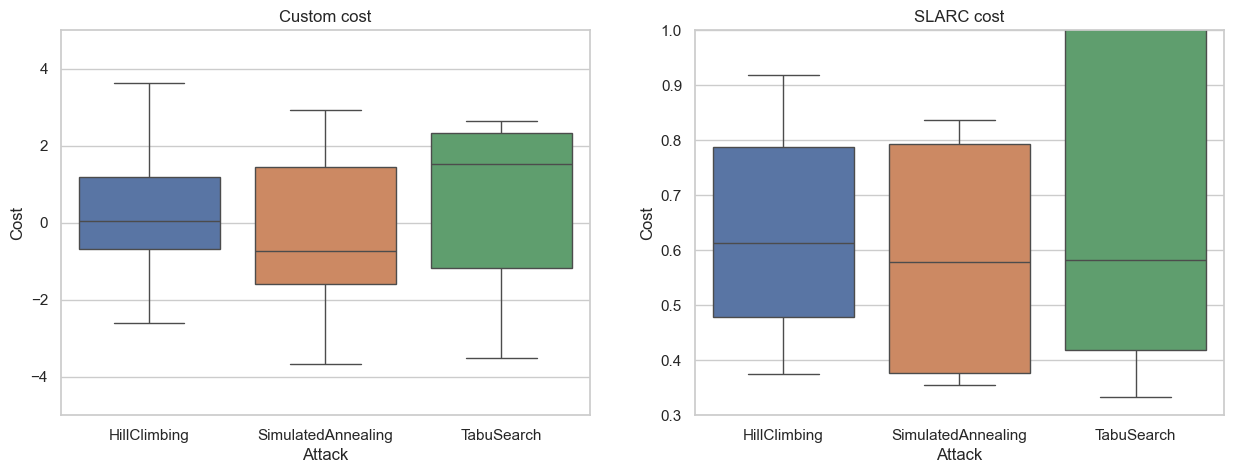

In [75]:
# Compare the scores from custom cost and SLARC cost.
# Custom cost information is in the files Credit_hc_best_absolute_scores_custom.npy, etc.
# SLARC cost information is in the files Credit_hc_best_absolute_scores.npy, etc.

hc_custom = np.load('Credit_hc_best_absolute_scores_custom.npy')
sa_custom = np.load('Credit_sa_best_absolute_scores_custom.npy')
ts_custom = np.load('Credit_ts_best_absolute_scores_custom.npy')

hc_slarc = np.load('Credit_hc_best_absolute_scores.npy')
sa_slarc = np.load('Credit_sa_best_absolute_scores.npy')
ts_slarc = np.load('Credit_ts_best_absolute_scores.npy')

# Make a DataFrame with the scores (column 'custom' and column 'SLARC').
# Compare the scores from custom cost and SLARC cost.
# Each row is a sample, and each column is an attack.
# 2 dataframes are made for the 2 cost functions.

# df_custom: 10 samples with the 3 custom costs. Add sampples using a for loop but first create columns.

df_custom = pd.DataFrame(columns=['HillClimbing', 'SimulatedAnnealing', 'TabuSearch'])
for i in range(8):
    df_custom.loc[i] = [hc_custom[i], sa_custom[i], ts_custom[i]]

# df_slarc: 10 samples with the 3 SLARC costs. Add sampples using a for loop but first create columns.

df_slarc = pd.DataFrame(columns=['HillClimbing', 'SimulatedAnnealing', 'TabuSearch'])
for i in range(8):
    df_slarc.loc[i] = [hc_slarc[i], sa_slarc[i], ts_slarc[i]]

# Plot with seaborn to compare how different attack strategies perform better depending on the chosen cost

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df_custom, ax=ax[0])
ax[0].set_title('Custom cost')
ax[0].set_ylabel('Cost')
ax[0].set_xlabel('Attack')
ax[0].set_ylim(-5, 5)
sns.boxplot(data=df_slarc, ax=ax[1])
ax[1].set_title('SLARC cost')
ax[1].set_ylabel('Cost')
ax[1].set_xlabel('Attack')
ax[1].set_ylim(0.3, 1)
plt.show()


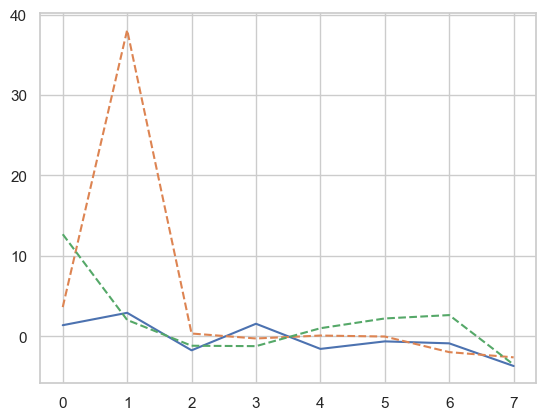

In [78]:
plt.plot(sa_custom)
plt.plot(hc_custom, linestyle='--')
plt.plot(ts_custom, linestyle='--')

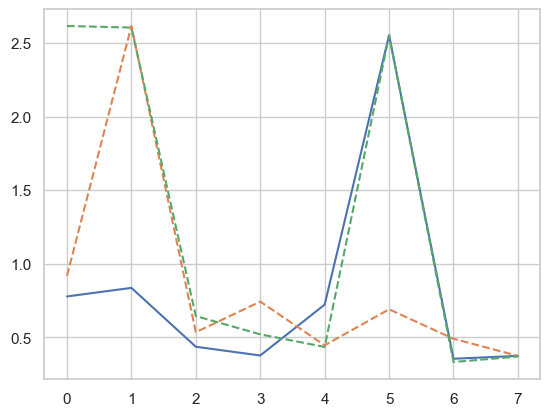

In [79]:
plt.plot(sa_slarc)
plt.plot(hc_slarc, linestyle='--')
plt.plot(ts_slarc, linestyle='--')

In [81]:
# Check when sa is better than hc and ts for both costs
# sa_better = (sa > hc) & (sa > ts)

sa_better_custom = (sa_custom > hc_custom) & (sa_custom > ts_custom)
sa_better_slarc = (sa_slarc > hc_slarc) & (sa_slarc > ts_slarc)

sa_better_custom == sa_better_slarc

array([ True,  True,  True, False, False, False,  True, False])